In [1]:
import import_parent

In [2]:
import tree_sim
tree_sim.EXPIRATION_TIME = 1e2
tree_sim.MEMORIES_PER_END_NODE=50

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import plot_sim_results

In [5]:
import ipywidgets

In [6]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from shutil import rmtree
import os
import pickle
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm as tqdm
%matplotlib widget
matplotlib.rcParams['toolbar'] = 'None'

In [7]:
init_data = {
    "p" : 1e-2,
    "k" : 4,
    "n" : 3,
    "b" : 1
}
sim = tree_sim.TreeSim(p=init_data["p"], k=init_data["k"], n=init_data["n"], t=np.inf, b=init_data["b"])

In [8]:
def run_sim_with_size(n, k, b, samples):
    dir_str = f"jupyter_example_data/animation_{n}_{k}_{b}_{int(tree_sim.EXPIRATION_TIME)}_{tree_sim.MEMORIES_PER_END_NODE}"
    if not os.path.exists(dir_str):   
        os.makedirs(dir_str)
        pool = Pool()
        l=cpu_count()
        
        params = [{"p" : 0.1**(1+2*i/(l-1)), "k" : k, "n" : n, "t" : "2e3", "b" : b, "resample" : samples} for i in range(l)]
        for result in tqdm(pool.imap_unordered(tree_sim.launch_sim_from_dict, params), total=l):
            os.makedirs(os.path.join(dir_str, f"n_{result['init_data'][2]}"), exist_ok=True) # The data is organized into subfolders based on the value of n.
            with open(os.path.join(dir_str, f"n_{result['init_data'][2]}/{result['init_data']}.data"), "wb") as f: # Each individual simulation has a data file, with a name based on its parameters.
                pickle.dump(result, f)

    plotdict = {
            "x" : "p",
            "y" : "rate",
            "indir" : dir_str,
            "legend" : True,
            }
    plot_sim_results.make_plot_from_dict(plotdict)

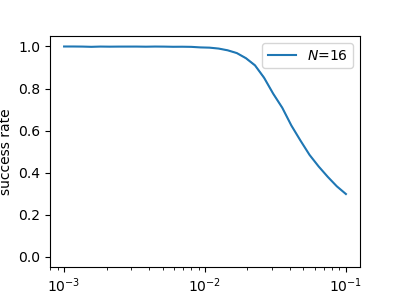

interactive(children=(Play(value=0, description='frame', interval=30, max=1000000), FloatLogSlider(value=0.02,…

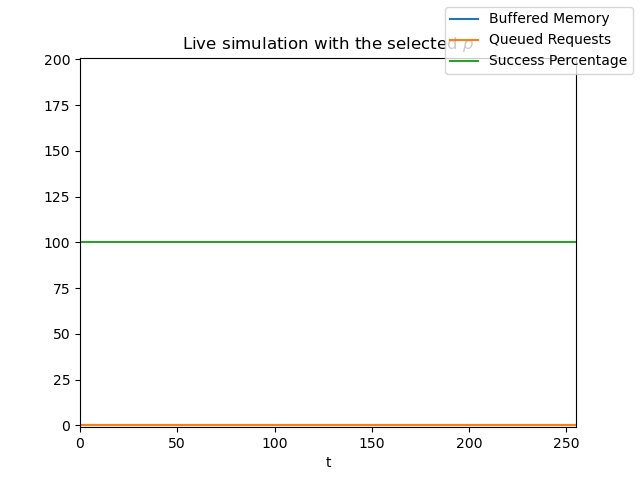

In [9]:
run_sim_with_size(init_data["n"],init_data["k"],init_data["b"],10)
vline = plt.axvline(0.02)
_ = plt.title("Sweep over values of $p$")

fig = plt.Figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas_footer_visible = False

datalength = 256
success_averaging_bins=16
memory_record = [0] * datalength
request_queue = [0] * datalength
success_stats = [100] * datalength
success_smooth = [100] * datalength
last_success_data = [0,0]

x_axis = list(range(datalength))
last_frame = [0]

fig, ax = plt.subplots()
memline, = ax.plot(x_axis, memory_record, label='Buffered Memory')
reqline, = ax.plot(x_axis, request_queue, label='Queued Requests')
success, = ax.plot(x_axis, success_stats, label='Success Percentage')
ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,201), title="Live simulation with the selected $p$", xlabel="t")

fig.legend()

def animate(frame, p):
    vline.set_xdata([p,p])
    if frame != last_frame[0]:
        last_frame[0] = frame
    else:
        return
    sim.p = p
    sim.time_cycle()
    d_sat = sim.requests_satisfied - last_success_data[0]
    d_exp = sim.requests_expired - last_success_data[1]
    
    request_count = sim.requests_enqueued - last_success_data[0] - last_success_data[1]
    # request_count = len(sim.request_queue) # this method doesn't show requests that get completed immediately
    last_success_data[0] = sim.requests_satisfied
    last_success_data[1] = sim.requests_expired
    success_rate = success_stats[-1]
    if d_sat + d_exp > 0:
        success_rate = d_sat * 100 / (d_sat + d_exp)
    new_data = sim.entanglements_made - sim.entanglements_used - sim.entanglements_expired
    memory_record.pop(0)
    memory_record.append(new_data)
    request_queue.pop(0)
    request_queue.append(request_count)
    success_stats.pop(0)
    success_stats.append(success_rate)
    success_smooth.pop(0)
    success_smooth.append(np.mean(success_stats[-success_averaging_bins:-1]))
    
    x_axis.pop(0)
    x_axis.append(x_axis[-1]+1)

    memline.set_data(x_axis, memory_record)
    reqline.set_data(x_axis, request_queue)
    success.set_data(x_axis, success_smooth)
    ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,201))
    
    
play = ipywidgets.interactive(animate, frame=ipywidgets.Play(0, 0, 1e6, 1, interval=30), p=ipywidgets.FloatLogSlider(0.02, base=10, min=-3, max=-1, step=0.05))
play